In [73]:
from IPython import get_ipython
from IPython.terminal import interactiveshell
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
from TinkeredBNN._bayesian_network import *
from TinkeredBNN._bayesianlayer import BayesianLayer
from TinkeredBNN._likelihood import Likelihood
from TinkeredBNN._learning_rate import StepDecay
import numpy as np
import matplotlib.pyplot as plt

# 1. Define some classic activation function

In [75]:
def ReLU(x):
    return np.maximum(0, x)

def ReLU_derivative(x):
    return x > 0

def leaky_ReLU(x):
    return np.maximum(0.1*x, x)

def leaky_ReLU_derivative(x):
    return x > 0.1*x

def logistic_function(x):
    return 1/(1 + np.exp(-x))

def logistic_derivative_function(x):
    return logistic_function(x)*(1 - logistic_function(x))

def tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def tanh_derivative(x):
    return 1 - tanh(x)**2

def identity(x):
    return x

def identity_d(x):
    return 1

# 2. Define dataset

In [76]:
def true_function(x, noise=0):
    # return np.maximum(0, x ) + noise
    # return np.maximum(0, np.maximum(0, x ) ) + noise
    return x**2 + x + 4  + noise
    # return logistic_function(logistic_function(x)) + noise

X_true = np.concatenate((np.linspace(-5, -2, 1000), np.linspace(-2, 2, 1000), np.linspace(2, 5, 100)))
X_true = X_true.reshape(1, -1)
noise = np.random.normal(scale=1, size=X_true.shape[1])
Y_true = true_function(X_true, noise=noise).reshape(1, -1)

X_true = (X_true - X_true.mean())/X_true.std()
Y_true = (Y_true - Y_true.mean())/Y_true.std()


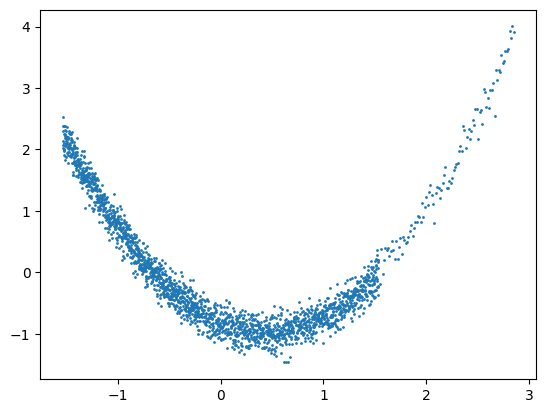

In [77]:
plt.scatter(X_true, Y_true, s=1)
plt.show()

# 3. Define and train a model

The model used is a very basic model : `1000 neurons with ReLU activation` and the output is a `regression` with the result of the neurons. \
We define a Step Decay for the learning rate to converge towards its local minimum and not deviate and explode from it. \
The `kl_weight` states how much the kullback divergence is impacting the total loss and the `likelihood` states how likely you think your data are.

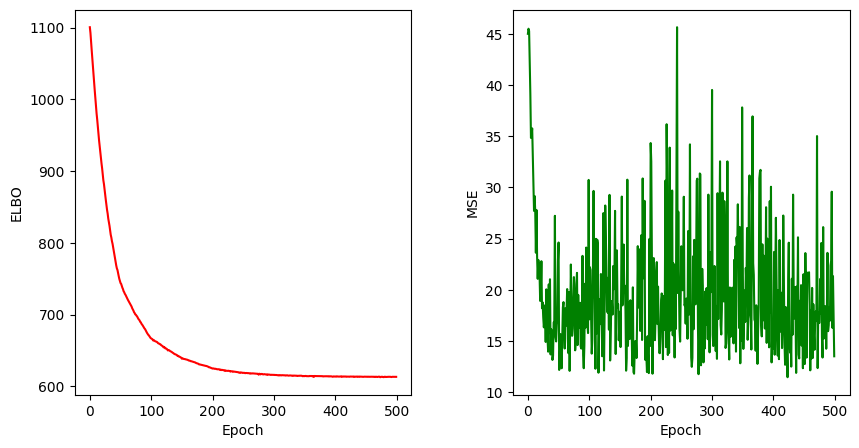

In [78]:
FirstLayer = BayesianLayer(1, 1000, ReLU, ReLU_derivative)
SecondLayer = BayesianLayer(1000, 1, identity, identity_d)
lr = StepDecay(0.001, 50, 0.5)
BNN = BayesianNetwork(FirstLayer, SecondLayer, likelihood = Likelihood(0, 1), lr = lr, kl_weight=0.9)

# You can choose if you want epoch count verbose, graph and the use of adam optimizer or not
BNN.train(X_true, Y_true, n_epoch=500, verbose=False, graph=True, adam=True)


# 4. Test model

To display the uncertainty of the prediction, we predict several times with the same input and plot all the predictions. \
We can see in the below graph that the width of the band increase where the points become more scarce.

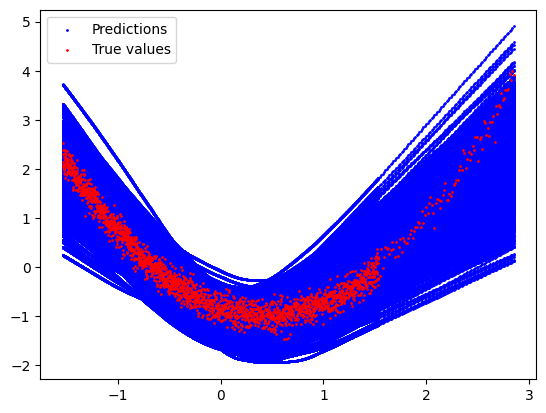

In [79]:
X = X_true
for _ in range(1000):
    BNN.generate_param()
    Ypred = BNN.predict(X)
    plt.scatter(np.squeeze(X), Ypred,  color='b', s=1)

plt.scatter(X_true, Y_true,  color='r', s=1, label="True value")
legend = plt.legend(['Predictions', 'True values'])
legend.legend_handles[0].set_color('blue')
legend.legend_handles[1].set_color('red')
plt.show()